# Code:

In [19]:
import numpy as np
import itertools
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

def simulate_customer(subset, v, r):
    exp_vals = np.array([v[i] for i in subset])
    denom = 1 + exp_vals.sum()
    probs = exp_vals / denom
    no_buy = 1 / denom
    choices = subset + [None]
    all_probs = np.append(probs, no_buy)
    choice = np.random.choice(choices, p=all_probs)
    reward = r[choice] if choice is not None else 0
    return choice, reward

def generate_subsets(N, max_size):
    subsets = []
    for size in range(1, max_size+1):
        for comb in itertools.combinations(range(N), size):
            subsets.append(list(comb))
    return subsets

def expected_reward(S, v, r):
    u = np.array([v[i] for i in S])
    return (r[S] * u).sum() / (1 + u.sum())

# =============================================================================
# Algorithm 1a: Exploration–Exploitation for MNL-Bandit
# =============================================================================
class MNLBanditEE:
    def __init__(self, N, r, subsets):
        self.N = N
        self.r = np.array(r)
        self.subsets = subsets
        self.v_ucb = np.ones(N)
        self.SumVbar = np.zeros(N)
        self.offered_epochs = {i: [] for i in range(N)}
        self.hist_vhat = {i: [] for i in range(N)}

    def select_S(self):
        best_S, best_val = None, -np.inf
        for S in self.subsets:
            u = self.v_ucb[S]
            val = (self.r[S] * u).sum() / (1 + u.sum())
            if val > best_val:
                best_S, best_val = S, val
        return best_S

    def run_with_regret(self, T, v_true, opt_reward):
        t, ell, L = 1, 1, 0
        E_l, purchases = [], []
        regrets, cum = [], 0.0

        while t <= T:
            if not E_l:
                S_l = self.select_S()

            # record regret
            cum += opt_reward - expected_reward(S_l, v_true, self.r)
            regrets.append(cum)

            # simulate and update
            choice, _ = simulate_customer(S_l, v_true, self.r)
            E_l.append(t)

            if choice is not None:
                purchases.append(choice)
                t += 1
                continue

            cnt = Counter(purchases)
            vhat_l = np.array([cnt[i] for i in range(self.N)])

            for i in S_l:
                self.offered_epochs[i].append(ell)
                self.hist_vhat[i].append(vhat_l[i])

            bar_v = np.zeros(self.N)
            for i in range(self.N):
                if self.hist_vhat[i]:
                    bar_v[i] = np.mean(self.hist_vhat[i])

            self.SumVbar += bar_v

            for i in range(self.N):
                Ti = len(self.offered_epochs[i])
                if Ti > 0:
                    logterm = np.log(np.sqrt(self.N) * ell + 1)
                    rad1 = np.sqrt(bar_v[i] * 48 * logterm / Ti)
                    rad2 = 48 * logterm / Ti
                    self.v_ucb[i] = bar_v[i] + rad1 + rad2
                else:
                    self.v_ucb[i] = 1.0

            L += 1
            ell += 1
            E_l.clear()
            purchases.clear()
            t += 1

        return regrets

# =============================================================================
# Algorithm 1b: UCB for MNL-Bandit Experiment
# =============================================================================
class MNLExperimentUCB:
    def __init__(self, N, r, subsets, alpha=0.1):
        self.N = N
        self.r = np.array(r)
        self.subsets = subsets
        self.alpha = alpha
        self.v_ucb = np.ones(N)
        self.SumVbar = np.zeros(N)
        self.offered_epochs = {i: [] for i in range(N)}
        self.hist_vhat = {i: [] for i in range(N)}

    def select_S_star(self):
        best_S, best_val = None, -np.inf
        for S in self.subsets:
            u = self.v_ucb[S]
            val = (self.r[S] * u).sum() / (1 + u.sum())
            if val > best_val:
                best_S, best_val = S, val
        return best_S

    def run_with_regret(self, T, v_true, opt_reward):
        t, ell, L = 1, 1, 0
        E_l, purchases = [], []
        regrets, cum = [], 0.0

        while t <= T:
            if not E_l:
                S_star = self.select_S_star()
                alpha_l = 1.0 / (2 * (ell ** self.alpha))
                if random.random() < 1 - alpha_l:
                    S_l, p_sel = S_star.copy(), 1 - alpha_l
                else:
                    S_l, p_sel = ([i for i in range(self.N) if i not in S_star], alpha_l)

            cum += opt_reward - expected_reward(S_l, v_true, self.r)
            regrets.append(cum)

            choice, _ = simulate_customer(S_l, v_true, self.r)
            E_l.append(t)

            if choice is not None:
                purchases.append(choice)
                t += 1
                continue

            cnt = Counter(purchases)
            vhat_l = np.array([cnt[i] for i in range(self.N)])

            for i in S_l:
                self.offered_epochs[i].append(ell)
                self.hist_vhat[i].append(vhat_l[i])

            bar_v = np.zeros(self.N)
            for i in range(self.N):
                if self.hist_vhat[i]:
                    bar_v[i] = np.mean(self.hist_vhat[i])

            for i in range(self.N):
                indicator = 1 if i in S_l else 0
                self.SumVbar[i] += indicator * bar_v[i] / max(p_sel, 1e-8)

            for i in range(self.N):
                Ti = len(self.offered_epochs[i])
                if Ti > 0:
                    logterm = np.log(np.sqrt(self.N) * ell + 1)
                    rad1 = np.sqrt(bar_v[i] * 48 * logterm / Ti)
                    rad2 = 48 * logterm / Ti
                    self.v_ucb[i] = bar_v[i] + rad1 + rad2
                else:
                    self.v_ucb[i] = 1.0

            L += 1
            ell += 1
            E_l.clear()
            purchases.clear()
            t += 1

        return regrets

# =============================================================================
# Algorithm 2: EXP3EG
# =============================================================================
class EXP3EG:
    def __init__(self, subsets, alpha=0.5, delta=0.05):
        self.subsets = subsets
        self.K = len(subsets)
        self.alpha = alpha
        self.delta = delta
        self.C = (4*self.K**2*(np.e**2+1)+2)**2 * (np.log(2/self.delta))**2
        self.A = list(range(self.K))
        self.Rhat = np.zeros(self.K)

    def select_arm(self, t):
        eps_t = 1.0 / np.sqrt(self.C * t)
        alpha_t = 1.0 / (self.K * (t**self.alpha))
        probs = np.full(self.K, alpha_t)
        if self.A:
            w = np.exp(eps_t * self.Rhat[self.A])
            norm = w.sum()
            for idx, a in enumerate(self.A):
                probs[a] = (1 - (self.K - len(self.A))*alpha_t) * w[idx] / norm
        probs /= probs.sum()
        arm = np.random.choice(self.K, p=probs)
        return arm, probs

    def update(self, arm, reward, probs, t):
        self.Rhat[arm] += reward / max(probs[arm], 1e-8)
        if arm in self.A:
            Rmax = max(self.Rhat[a] for a in self.A)
            self.A = [a for a in self.A if Rmax - self.Rhat[a] <= 2*np.sqrt(self.C*t)]

    def run_with_regret(self, T, v_true, r, opt_reward):
        regrets, cum = [], 0.0
        for t in range(1, T+1):
            arm, probs = self.select_arm(t)
            S = self.subsets[arm]
            cum += opt_reward - expected_reward(S, v_true, r)
            regrets.append(cum)
            choice, rew = simulate_customer(S, v_true, r)
            self.update(arm, rew, probs, t)
        return regrets


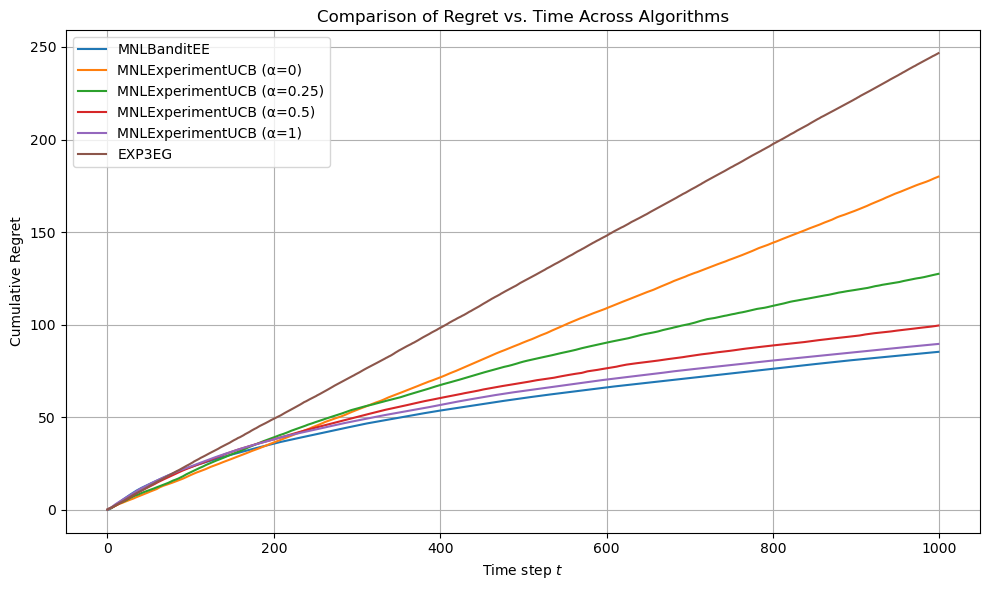

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


def plot_all_algorithms(alphas, runs=20, N=5, T=1000, max_size=5):
    subsets = generate_subsets(N, max_size)

    acc = defaultdict(lambda: np.zeros(T))
    acc['EE'] = np.zeros(T)
    acc['EXP'] = np.zeros(T)
    for alpha in alphas:
        acc[f'UCB_{alpha}'] = np.zeros(T)

    for _ in range(runs):
        v_true = np.random.uniform(0.1, 1.0, size=N)
        r      = np.random.uniform(0.5, 1.5, size=N)
        opt_reward = max(expected_reward(S, v_true, r) for S in subsets)

        # 1) MNLBanditEE
        ee = MNLBanditEE(N, r, subsets)
        regEE = ee.run_with_regret(T, v_true, opt_reward)
        acc['EE'] += np.array(regEE)

        # 2) MNLExperimentUCB: 
        for alpha in alphas:
            ucb = MNLExperimentUCB(N, r, subsets, alpha=alpha)
            regUCB = ucb.run_with_regret(T, v_true, opt_reward)
            acc[f'UCB_{alpha}'] += np.array(regUCB)

        # 3) EXP3EG
        exp3 = EXP3EG(subsets)
        regEXP = exp3.run_with_regret(T, v_true, r, opt_reward)
        acc['EXP'] += np.array(regEXP)

    for k in acc:
        acc[k] /= runs

    plt.figure(figsize=(10,6))
    plt.plot(acc['EE'],     label='MNLBanditEE')
    for alpha in alphas:
        plt.plot(acc[f'UCB_{alpha}'], label=f'MNLExperimentUCB (α={alpha})')
    plt.plot(acc['EXP'],    label='EXP3EG')

    plt.xlabel("Time step $t$")
    plt.ylabel("Cumulative Regret")
    plt.title("Comparison of Regret vs. Time Across Algorithms")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    alphas = [0, 0.25, 0.5, 1]
    plot_all_algorithms(alphas, runs=20, N=10, T=1000, max_size=5)


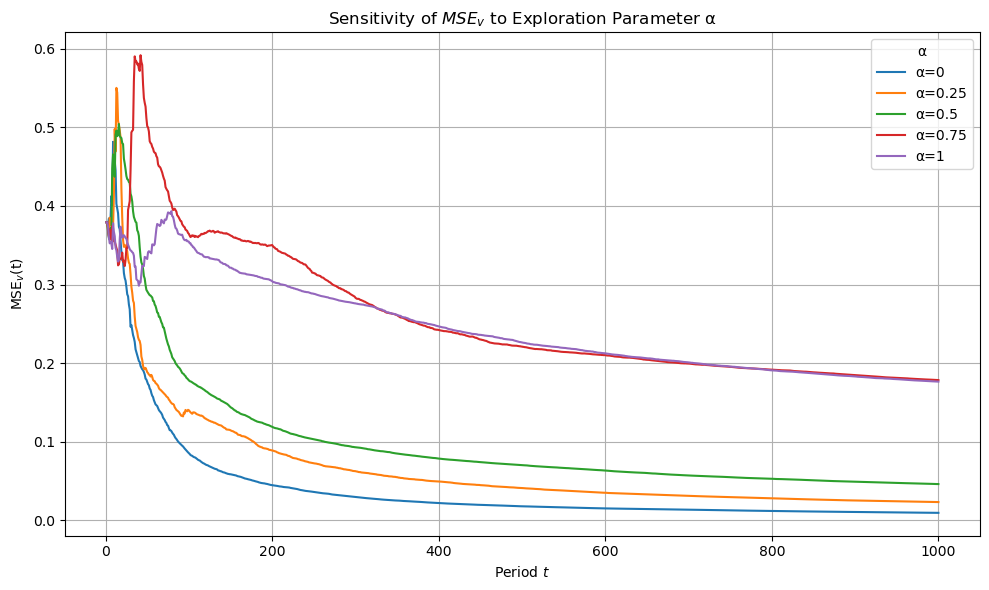

In [21]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# ----------------------------
# Helper functions
# ----------------------------
def simulate_customer(subset, v, r):
    exp_vals = np.array([v[i] for i in subset])
    denom = 1 + exp_vals.sum()
    probs = exp_vals / denom
    no_buy = 1 / denom
    choices = subset + [None]
    all_probs = np.append(probs, no_buy)
    choice = np.random.choice(choices, p=all_probs)
    reward = r[choice] if choice is not None else 0
    return choice, reward

def generate_subsets(N, max_size):
    subsets = []
    for size in range(1, max_size+1):
        for comb in itertools.combinations(range(N), size):
            subsets.append(list(comb))
    return subsets

# =============================================================================
# MNLExperimentUCB with MSE_v tracing
# =============================================================================
class MNLExperimentUCB:
    def __init__(self, N, r, subsets, alpha=0.1):
        self.N = N
        self.r = np.array(r)
        self.subsets = subsets
        self.alpha = alpha

        # Initialization
        self.v_ucb = np.ones(N)
        self.SumVbar = np.zeros(N)
        self.offered_epochs = {i: [] for i in range(N)}
        self.hist_vhat = {i: [] for i in range(N)}

    def select_S_star(self):
        best_S, best_val = None, -np.inf
        for S in self.subsets:
            u = self.v_ucb[S]
            val = (self.r[S] * u).sum() / (1 + u.sum())
            if val > best_val:
                best_S, best_val = S, val
        return best_S

    def run_with_MSE_v(self, T, v_true):
        t, ell, L = 1, 1, 0
        E_l, purchases = [], []
        mse_trace = np.zeros(T)

        while t <= T:
            if not E_l:
                # compute exploration probability α_ℓ correctly
                alpha_l = 1.0 / (2 * (ell ** self.alpha))
                S_star = self.select_S_star()
                if random.random() < 1 - alpha_l:
                    S_l, p_sel = S_star.copy(), 1 - alpha_l
                else:
                    S_l = [i for i in range(self.N) if i not in S_star]
                    p_sel = alpha_l

            # compute current v_hat and MSE_v
            if L > 0:
                v_hat = self.SumVbar / L
            else:
                v_hat = np.zeros(self.N)
            mse_trace[t-1] = np.mean((v_hat - v_true)**2)

            # simulate one customer and record
            choice, _ = simulate_customer(S_l, v_true, self.r)
            E_l.append(t)

            if choice is not None:
                purchases.append(choice)
                t += 1
                continue

            cnt = Counter(purchases)
            vhat_l = np.array([cnt[i] for i in range(self.N)])

            for i in S_l:
                self.offered_epochs[i].append(ell)
                self.hist_vhat[i].append(vhat_l[i])

            bar_v = np.zeros(self.N)
            for i in range(self.N):
                if self.hist_vhat[i]:
                    bar_v[i] = np.mean(self.hist_vhat[i])

            self.SumVbar += bar_v

            # update v_ucb
            for i in range(self.N):
                Ti = len(self.offered_epochs[i])
                if Ti > 0:
                    logterm = np.log(np.sqrt(self.N) * ell + 1)
                    rad1 = np.sqrt(bar_v[i] * 48 * logterm / Ti)
                    rad2 = 48 * logterm / Ti
                    self.v_ucb[i] = bar_v[i] + rad1 + rad2
                else:
                    self.v_ucb[i] = 1.0

            # advance epoch
            L += 1
            ell += 1
            E_l.clear()
            purchases.clear()
            t += 1

        return mse_trace

# ===============================
# Experiment and plotting
# ===============================
def plot_MSE_v_sensitivity(alphas, runs=20, N=5, T=1000, max_size=3):
    subsets = generate_subsets(N, max_size)
    all_traces = {a: np.zeros((runs, T)) for a in alphas}

    for run in range(runs):
        v_true = np.random.uniform(0.1, 1.0, size=N)
        r      = np.random.uniform(0.5, 1.5, size=N)
        for alpha in alphas:
            algo = MNLExperimentUCB(N, r, subsets, alpha=alpha)
            trace = algo.run_with_MSE_v(T, v_true)
            all_traces[alpha][run] = trace

    # compute mean and std
    mean_traces = {a: all_traces[a].mean(axis=0) for a in alphas}
    std_traces  = {a: all_traces[a].std(axis=0)  for a in alphas}

    plt.figure(figsize=(10, 6))
    t = np.arange(1, T+1)
    for alpha in alphas:
        μ = mean_traces[alpha]
        σ = std_traces[alpha]
        plt.plot(t, μ, label=f'α={alpha}')
        #plt.fill_between(t, μ-σ, μ+σ, alpha=0.2)
    plt.xlabel("Period $t$")
    plt.ylabel("MSE$_v$(t)")
    plt.title("Sensitivity of $MSE_v$ to Exploration Parameter α")
    plt.legend(title="α")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    alphas = [0, 0.25, 0.5, 0.75, 1]
    plot_MSE_v_sensitivity(alphas, runs=20, N=10, T=1000, max_size=5)


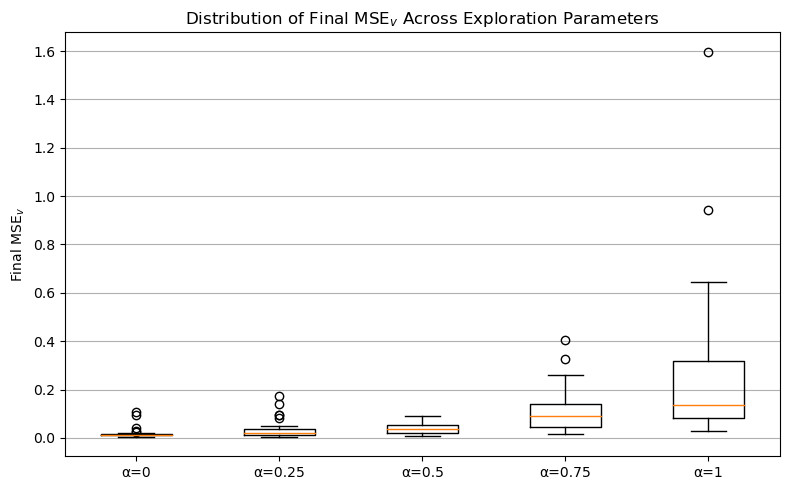

In [22]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from collections import Counter

# ----------------------------
# Helper functions 
# ----------------------------
def simulate_customer(subset, v, r):
    exp_vals = np.array([v[i] for i in subset])
    denom = 1 + exp_vals.sum()
    probs = exp_vals / denom
    no_buy = 1 / denom
    choices = subset + [None]
    all_probs = np.append(probs, no_buy)
    choice = np.random.choice(choices, p=all_probs)
    reward = r[choice] if choice is not None else 0
    return choice, reward

def generate_subsets(N, max_size):
    subsets = []
    for size in range(1, max_size+1):
        for comb in itertools.combinations(range(N), size):
            subsets.append(list(comb))
    return subsets

# =============================================================================
# MNLExperimentUCB with final MSE_v computation
# =============================================================================
class MNLExperimentUCB:
    def __init__(self, N, r, subsets, alpha=0.1):
        self.N = N
        self.r = np.array(r)
        self.subsets = subsets
        self.alpha = alpha
        # initialize
        self.v_ucb = np.ones(N)
        self.SumVbar = np.zeros(N)
        self.offered_epochs = {i: [] for i in range(N)}
        self.hist_vhat = {i: [] for i in range(N)}

    def select_S_star(self):
        best_S, best_val = None, -np.inf
        for S in self.subsets:
            u = self.v_ucb[S]
            val = (self.r[S] * u).sum() / (1 + u.sum())
            if val > best_val:
                best_S, best_val = S, val
        return best_S

    def run_and_get_final_MSE_v(self, T, v_true):
        t, ell, L = 1, 1, 0
        E_l, purchases = [], []
        while t <= T:
            if not E_l:
                alpha_l = 1.0 / (2 * (ell ** self.alpha))
                S_star = self.select_S_star()
                if random.random() < 1 - alpha_l:
                    S_l, p_sel = S_star.copy(), 1 - alpha_l
                else:
                    S_l = [i for i in range(self.N) if i not in S_star]
                    p_sel = alpha_l

            choice, _ = simulate_customer(S_l, v_true, self.r)
            E_l.append(t)
            if choice is not None:
                purchases.append(choice)
                t += 1
                continue

            cnt = Counter(purchases)
            vhat_l = np.array([cnt[i] for i in range(self.N)])
            for i in S_l:
                self.offered_epochs[i].append(ell)
                self.hist_vhat[i].append(vhat_l[i])

            bar_v = np.zeros(self.N)
            for i in range(self.N):
                if self.hist_vhat[i]:
                    bar_v[i] = np.mean(self.hist_vhat[i])

            self.SumVbar += bar_v
            for i in range(self.N):
                Ti = len(self.offered_epochs[i])
                if Ti > 0:
                    logterm = np.log(np.sqrt(self.N) * ell + 1)
                    rad1 = np.sqrt(bar_v[i] * 48 * logterm / Ti)
                    rad2 = 48 * logterm / Ti
                    self.v_ucb[i] = bar_v[i] + rad1 + rad2
                else:
                    self.v_ucb[i] = 1.0

            L += 1
            ell += 1
            E_l.clear()
            purchases.clear()
            t += 1

        # final v_hat and MSE_v
        v_hat = self.SumVbar / max(L, 1)
        mse_v = np.mean((v_hat - v_true) ** 2)
        return mse_v

# ===============================
# Boxplot of final MSE_v across alphas
# ===============================
def boxplot_final_MSE_v(alphas, runs=30, N=5, T=1000, max_size=5):
    subsets = generate_subsets(N, max_size)
    results = {alpha: [] for alpha in alphas}

    for _ in range(runs):
        v_true = np.random.uniform(0.1, 1.0, size=N)
        r = np.random.uniform(0.5, 1.5, size=N)
        for alpha in alphas:
            algo = MNLExperimentUCB(N, r, subsets, alpha=alpha)
            mse_final = algo.run_and_get_final_MSE_v(T, v_true)
            results[alpha].append(mse_final)

    # prepare data for boxplot
    data = [results[a] for a in alphas]
    labels = [f'α={a}' for a in alphas]

    plt.figure(figsize=(8,5))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.ylabel("Final MSE$_v$")
    plt.title("Distribution of Final MSE$_v$ Across Exploration Parameters")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    alphas = [0,0.25, 0.5, 0.75,1]
    boxplot_final_MSE_v(alphas, runs=20, N=10, T=1000, max_size=5)


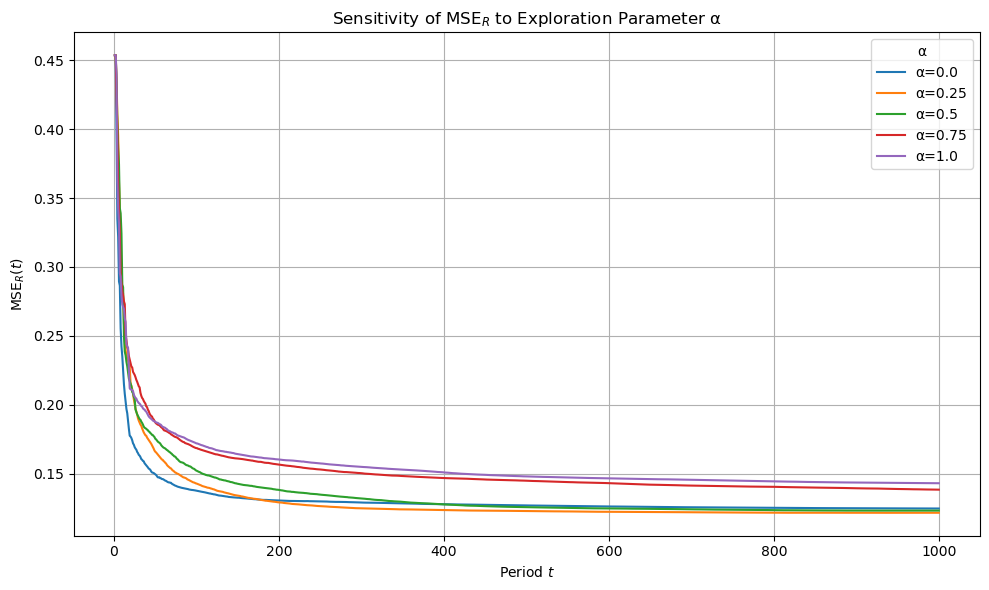

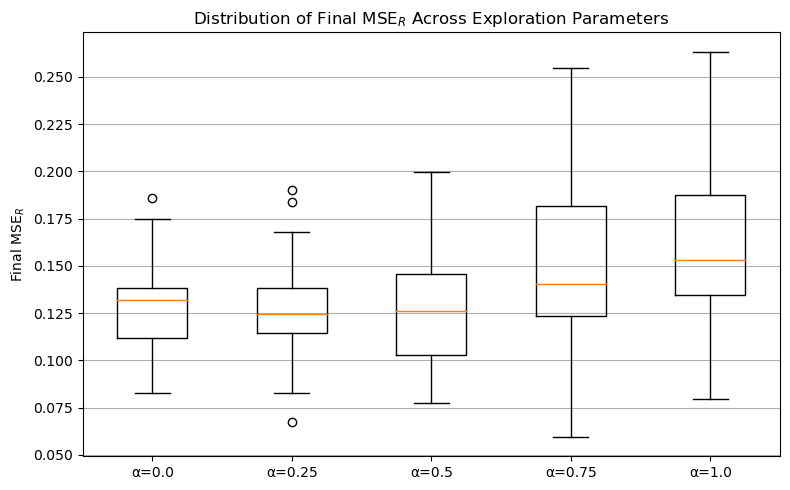

In [ ]:
from __future__ import annotations

from collections import Counter, defaultdict
from dataclasses import dataclass, field
from typing import List, Sequence

import itertools
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# Helper functions
# -----------------------------------------------------

def simulate_customer(
    subset: Sequence[int],
    v: np.ndarray,
    r: np.ndarray,
    rng: np.random.Generator,
):
    u = v[list(subset)]
    denom = 1.0 + u.sum()
    probs = u / denom
    p_no = 1.0 / denom

    choices = np.append(subset, [None])
    all_probs = np.append(probs, p_no)
    choice = rng.choice(choices, p=all_probs)
    reward = 0.0 if choice is None else r[int(choice)]
    return choice, reward

def generate_subsets(N: int, max_size: int):
    subsets: list[list[int]] = []
    for size in range(1, max_size + 1):
        subsets.extend([list(comb) for comb in itertools.combinations(range(N), size)])
    return subsets

def expected_reward(S: Sequence[int], v: np.ndarray, r: np.ndarray):
    if not S:
        return 0.0
    u = v[list(S)]
    return r[list(S)].dot(u) / (1.0 + u.sum())

@dataclass
class MNLExperimentUCB:
    N: int
    r: np.ndarray
    subsets: Sequence[Sequence[int]]
    alpha: float = 0.1
    seed: int | None = None

    rng: np.random.Generator = field(init=False)
    v_ucb: np.ndarray = field(init=False)
    SumVbar: np.ndarray = field(init=False)
    offered_epochs: dict[int, list[int]] = field(init=False)
    hist_vhat: dict[int, list[float]] = field(init=False)

    def __post_init__(self):
        self.rng = np.random.default_rng(self.seed)
        self.v_ucb = np.ones(self.N, dtype=float)
        self.SumVbar = np.zeros(self.N, dtype=float)
        self.offered_epochs = defaultdict(list)
        self.hist_vhat = defaultdict(list)

    def _select_S_star(self) -> Sequence[int]:
        numer = []
        denom = []
        for S in self.subsets:
            u = self.v_ucb[list(S)]
            rS = self.r[list(S)]
            numer.append((rS * u).sum())
            denom.append(1.0 + u.sum())
        numer = np.array(numer)
        denom = np.array(denom)
        best_idx = int(np.argmax(numer / denom))
        return self.subsets[best_idx]

    def _random_explore_subset(self, S_star: Sequence[int]):
        idx = self.rng.integers(0, len(self.subsets))
        while self.subsets[idx] == S_star:
            idx = self.rng.integers(0, len(self.subsets))
        return self.subsets[idx]

    def run_with_MSE_R(self, T: int, v_true: np.ndarray, r_true: np.ndarray):
        R_true = np.array([expected_reward(S, v_true, r_true) for S in self.subsets])
        mse_trace = np.zeros(T)

        t, ell, L = 1, 1, 0
        E_l: list[int] = []
        purchases: list[int] = []

        while t <= T:
            if not E_l:
                alpha_l = 1.0 / (2 * (ell ** self.alpha))
                S_star = self._select_S_star()
                if self.rng.random() < 1 - alpha_l:
                    S_l = list(S_star)
                else:
                    S_l = self._random_explore_subset(S_star)

            if L > 0:
                v_hat = self.SumVbar / L
            else:
                v_hat = np.zeros(self.N)
            R_est = np.array([
                (self.r[S] * v_hat[S]).sum() / (1.0 + v_hat[S].sum()) for S in self.subsets
            ])
            mse_trace[t - 1] = np.mean((R_est - R_true) ** 2)

            choice, _ = simulate_customer(S_l, v_true, r_true, self.rng)
            E_l.append(t)
            if choice is not None:
                purchases.append(int(choice))
                t += 1
                continue

            total_offers = len(E_l)
            cnt = Counter(purchases)
            vhat_l = np.array([cnt.get(i, 0) / total_offers for i in range(self.N)], dtype=float)

            for i in S_l:
                self.offered_epochs[i].append(ell)
                self.hist_vhat[i].append(vhat_l[i])

            bar_v = np.array([
                np.mean(self.hist_vhat[i]) if self.hist_vhat[i] else 0.0 for i in range(self.N)
            ])
            self.SumVbar += bar_v

            logterm = np.log(np.sqrt(self.N) * ell + 1.0)
            for i in range(self.N):
                Ti = len(self.offered_epochs[i])
                if Ti == 0:
                    self.v_ucb[i] = 1.0
                    continue
                rad1 = np.sqrt(bar_v[i] * 48.0 * logterm / Ti)
                rad2 = 48.0 * logterm / Ti
                self.v_ucb[i] = bar_v[i] + rad1 + rad2

            L += 1
            ell += 1
            E_l.clear()
            purchases.clear()
            t += 1

        return mse_trace

    def run_and_get_final_MSE_R(self, T: int, v_true: np.ndarray, r_true: np.ndarray):
        return self.run_with_MSE_R(T, v_true, r_true)[-1]


def plot_MSE_R_sensitivity(
    alphas: Sequence[float],
    runs: int = 20,
    N: int = 10,
    T: int = 1000,
    max_size: int = 5,
    seed: int | None = None,
):
    subsets = generate_subsets(N, max_size)
    all_traces = {a: np.zeros((runs, T)) for a in alphas}
    base_rng = np.random.default_rng(seed)

    for run in range(runs):
        v_true = base_rng.uniform(0.1, 1.0, size=N)
        r_true = base_rng.uniform(0.5, 1.5, size=N)
        for alpha in alphas:
            algo = MNLExperimentUCB(N, r_true, subsets, alpha=alpha, seed=base_rng.integers(1e9))
            all_traces[alpha][run] = algo.run_with_MSE_R(T, v_true, r_true)

    t_axis = np.arange(1, T + 1)
    plt.figure(figsize=(10, 6))
    for alpha in alphas:
        μ = all_traces[alpha].mean(0)
        σ = all_traces[alpha].std(0)
        plt.plot(t_axis, μ, label=f"α={alpha}")
        #plt.fill_between(t_axis, μ - σ, μ + σ, alpha=0.2)
    plt.xlabel("Period $t$")
    plt.ylabel(r"MSE$_R(t)$")
    plt.title("Sensitivity of MSE$_R$ to Exploration Parameter α")
    plt.legend(title="α")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def boxplot_final_MSE_R(
    alphas: Sequence[float],
    runs: int = 20,
    N: int = 10,
    T: int = 1000,
    max_size: int = 5,
    seed: int | None = None,
):
    subsets = generate_subsets(N, max_size)
    results = {alpha: [] for alpha in alphas}
    base_rng = np.random.default_rng(seed)

    for _ in range(runs):
        v_true = base_rng.uniform(0.1, 1.0, size=N)
        r_true = base_rng.uniform(0.5, 1.5, size=N)
        for alpha in alphas:
            algo = MNLExperimentUCB(N, r_true, subsets, alpha=alpha, seed=base_rng.integers(1e9))
            results[alpha].append(algo.run_and_get_final_MSE_R(T, v_true, r_true))

    data = [results[a] for a in alphas]
    labels = [f"α={a}" for a in alphas]

    plt.figure(figsize=(8, 5))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.ylabel("Final MSE$_R$")
    plt.title("Distribution of Final MSE$_R$ Across Exploration Parameters")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
    plot_MSE_R_sensitivity(alphas, runs=20, seed=42)
    boxplot_final_MSE_R(alphas, runs=20, seed=123)
